<a href="https://colab.research.google.com/github/scottcanoe/SequenceLearning/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learned Response Dynamics Provide Ambiguous Evidence of Predictive Coding in Superficial Layers of Mouse V1
Paper authors: Scott Knudstrup, Catalina Martinez, Jeffrey Gavornik
<br>Notebook author: Scott Knudstrup
<br><br>
This notebook accompanies Knudstrup et al. 2023 (link). In this paper, we investigated how exposure to visual sequences modifies brain activity in layer 2/3 of mouse primary visual cortex.
<br><br>
###Introduction
- We used a multi-day, passive sequence learning paradigm in order to investigate several aspects of learning and expectation.
- First, we looked for prediction errors. Under the predictive processing framework, these are thought to be abundant in layer 2/3 and take the form of elevated activity during events that violate expectations.
- Second, we looked at how activity at the population level changes with exposuure. In particular, we looked exposure facilitated changes in the dimensionality and density of neural responses.
- Third, we investigated how exposure drove changes to the temporal coordination of neural activity.

###Background (in layman's terms)
- When we encounter things that tend to happen one after the other, we automatically pick up on how their order. For example, if I show you three images ('dog, 'cat', 'beach') over and over (and in that order), you will learn to expect 'cat' after you see 'dog'. If 'cat' does not come after dog, this violates an expectation.
- We also learn the timing of events. If I showed you the images 'dog', 'cat', and 'beach', and each image lasted exactly one second, you would probably notice if I suddenly broke the rhythm by showing an image way early or later than expected.
- We don't really know how the brain does this.

###Data
Data can be found [here](https://drive.google.com/drive/folders/1UFtn02RWI61EJdWjNzvZ-auOD29QgdJs?usp=drive_link). Briefly, we have:
- `traces.h5`: An h5 file containing deconvolved fluorescence data. It has two groups ('day_0' and 'day_5'), and each group has three datasets ('ABCD', 'ABBD', 'ACBD'). Datasets have dimensions ('trial', 'time', 'roi'). There are 500 trials and 56 timepoints. There are 1368 and 1500 ROIs on days 0 and 5, respectively. In these arrays, stimuli occur for 8 timepoints each, so 'A' in 'ABCD' corresponds to timepoints 0 through 7 (inclusive). The gray period following sequence presentations is also included at positions 32 through 56. ROIs were pooled across 7 mice, and the data here contained the fully preprocessed and curated data used in the paper.
- `stimulus_selectivity.xlsx`: An excel file containing two sheets ('day_0', 'day_5'). This contains information about what each ROI is selective for (if any). Analyses that led to these classifications is not included in the notebook but is detailed the paper.

###Modules
We're using the basic scientific stack (numpy, scipy, scikit-learn, matplotlib, etc.) as well as [xarray](https://xarray.dev/). To keep this document clean, I've stashed some helper functions for data loading and plotting utilies in utils.py located in the same directory of this notebook ([here](https://drive.google.com/drive/folders/1UFtn02RWI61EJdWjNzvZ-auOD29QgdJs?usp=drive_link)).


In [1]:
# built-ins
import json
from pathlib import Path
import sys
from typing import Optional, Tuple

# third-party
from cycler import cycler
import h5py
from IPython.display import display
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from PIL import Image
from scipy.stats import ecdf, gaussian_kde, ks_2samp, pearsonr
from sklearn.decomposition import PCA
from statsmodels.distributions.empirical_distribution import ECDF
import xarray as xr

# connect to google drive for data and helper modules
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/My Drive/Colab Notebooks/Public/Sequence Learning/')

# import local helper modules
import utils

# paths/file stuff
PARENT_DIR = Path('/content/drive/My Drive/Colab Notebooks/Public/Sequence Learning')
DATA_DIR = PARENT_DIR / 'data'

Mounted at /content/drive


Let's quickly get an overview of what the data looks like.

##Introduction
We performed two-photon calcium imaging of excitatory layer 2/3 cells mouse V1 (n=7 mice) while passively viewing sequences of oriented gratings (see below). The 'base' sequence (ABCD) was composed of four images, each shown for 250 ms, and sequences were separated by 1 s of gray screen. In addition to ABCD, there was ABBD (B held over in place of C) and ACBD (B and C switched) places. Mice first saw all three sequences (day 0), and after two days, they began a four-day training period in which they only saw ABCD. On the fifth day (day 5), mice saw all three sequences again. The purpose of this design was to create temporal associations between the images during training days and look for prediction errors when the mouse saw the 'deviant' sequences on day 5. Day 0 was used as a baseline against which day 5 data was compared.


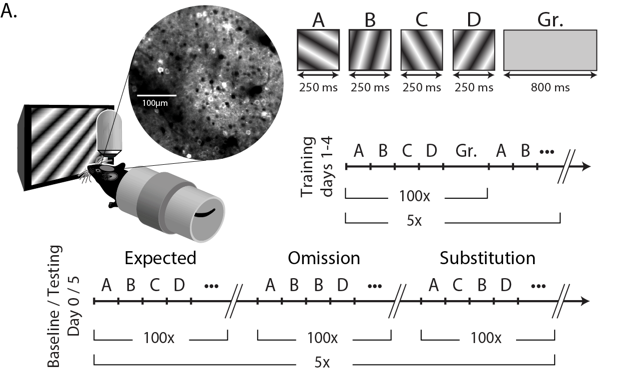

In [2]:
# Display part of figure 1
img = Image.open(PARENT_DIR / 'images/Figure_1.png')
img = img.crop((0, 0, 1235, 755))
img = img.resize((int(img.width / 2), int(img.height / 2)))
display(img)


Let's take a look at what responses look like on days 0 and 5.

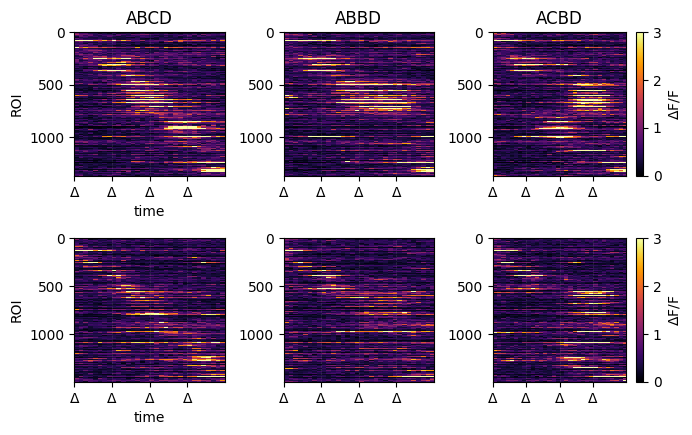

In [3]:
def get_heatmap_data(day: int, sequence: str, sort_by: np.ndarray) -> xr.DataArray:
    """Get mean traces for a given day and sequence.

    This function splits the trials into even and odd groups, and
    uses the even trials to sort the odd trial data. Returned data
    is from odd trials only and is the average over all odd trials.
    It is sorted by location of peak activity in the even trials.

    """
    data = utils.load_traces(day, sequence, drop_gray=True)

    # Extract odd trials, and average over trials.
    odd = data.isel(trial=np.arange(1, 500, 2)).mean('trial')

    # sort by given sorting index
    odd = odd.isel(roi=sort_by).transpose('roi', ...)

    return odd


def add_heatmap(
    ax: "matplotlib.axis.Axes",
    arr: xr.DataArray,
    title: str = "",
    colorbar: bool = False,
) -> "matplotlib.image.AxisImage":

    # vmin, vmax = np.percentile(arr, [2.5, 97.5])
    vmin, vmax = [0, 3]
    im = ax.imshow(
        arr,
        'inferno',
        vmin=vmin,
        vmax=vmax,
        aspect="auto",
        interpolation='none',
    )
    utils.annotate_onsets(
        ax,
        arr.coords["event"],
        skip_first=False,
        color='gray',
        alpha=0.3,
        # last='-',
        shift=-0.5,
        lw=0.5,
    )
    ax.set_title(title)

    if colorbar:
        divider = make_axes_locatable(ax)
        ax_cb = divider.append_axes("right", size="5%", pad=0.1)
        fig.add_axes(ax_cb)
        cbar = plt.colorbar(im, cax=ax_cb)
        ax_cb.yaxis.tick_right()
        ax_cb.yaxis.set_tick_params(labelright=True)
        ax_cb.set_ylabel(r'$\Delta$F/F')

    return im


# Get sorting order for days 0 and 5.
# - day 0
data = utils.load_traces(0, 'ABCD', drop_gray=True)
even = data.isel(trial=np.arange(0, 500, 2)).mean('trial')
day_0_sort = np.argsort(even.argmax('time'))
# - day 5
data = utils.load_traces(5, 'ABCD', drop_gray=True)
even = data.isel(trial=np.arange(0, 500, 2)).mean('trial')
day_5_sort = np.argsort(even.argmax('time'))
del data, even

# Collect all data going into heatmaps.
ABCD_0 = get_heatmap_data(0, 'ABCD', day_0_sort)
ABBD_0 = get_heatmap_data(0, 'ABBD', day_0_sort)
ACBD_0 = get_heatmap_data(0, 'ACBD', day_0_sort)
ABCD_5 = get_heatmap_data(5, 'ABCD', day_5_sort)
ABBD_5 = get_heatmap_data(5, 'ABBD', day_5_sort)
ACBD_5 = get_heatmap_data(5, 'ACBD', day_5_sort)

# Plot heatmaps.
fig, axes = plt.subplots(2, 3, figsize=(7, 4.43))

ax, arr = axes[0, 0], ABCD_0
add_heatmap(ax, arr, 'ABCD')
ax.set_xlabel('time')
ax.set_ylabel('ROI')

ax, arr = axes[0, 1], ABBD_0
add_heatmap(ax, arr, 'ABBD')

ax, arr = axes[0, 2], ACBD_0
add_heatmap(ax, arr, 'ACBD', colorbar=True)

ax, arr = axes[1, 0], ABCD_5
add_heatmap(ax, arr)
ax.set_xlabel('time')
ax.set_ylabel('ROI')

ax, arr = axes[1, 1], ABBD_5
add_heatmap(ax, arr)

ax, arr = axes[1, 2], ACBD_5
add_heatmap(ax, arr, colorbar=True)

fig.tight_layout(pad=1)
plt.show()

Responses on day 0 are in the top row, and responses on day 5 are in the bottom row. Each row in the heatmap corresponds to the trial-averaged responses (odd trials only) of a given cell. We cross-validated the sorting order by showing only odd trial data but using even trial data to extract the sorting order. All plots are sorted by activity during ABCD. Intersequence gray periods are excluded. Triangles on the x-axis indicate when the stimulus changed (each lasts for 250 ms).

##Prediction errors
We want to determine whether training with ABCD drives prediction errors during omissions (e.g., AB**B**D) and substitutions (e.g., A**C**BD). The basic model for prediction errors under the predictive processing framework looks something like this:


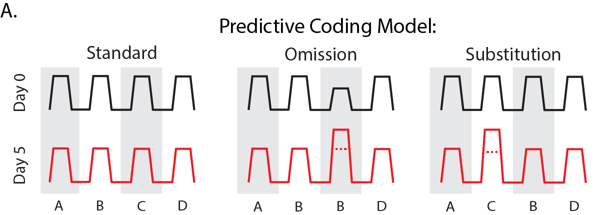

In [4]:
img = Image.open(PARENT_DIR / 'images/Figure_2_diagram.png')
img = img.resize((int(img.width / 2), int(img.height / 2)))
display(img)

In short, prediction errors take the form of elevated activity during an expectation violation. Also part of the theory is that prediction errors are specific to the identity of the omitted or substituted stimulus. For this reason, our analyses of prediction errors focuses on cells that are selective for stimulus B (for ABBD) and stimulus C (for ACBD).



(1232, 1508)


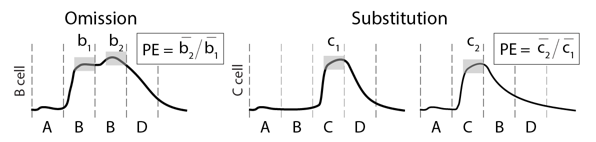

In [5]:
img = Image.open(PARENT_DIR / 'images/Figure_2.png')
print(img.size)
img = img.crop((40, 450, 1232, 735))
img = img.resize((int(img.width / 2), int(img.height / 2)))
display(img)

To quantify prediction errors, we introduced a measure (PE ratio) that compares activity during an unexpected stimulus with activity during the same stimulus in an expected context. For omission errors, that mean comparing ABBD with ABCD. For substitution errors, that mean comparig ACBD with ABCD. This is done on a cell-by-cell basis. See the below diagram showing how and why we measure prediction errors this way.

###Omission Prediction Errors
The following code plots the mean traces of B-selective cells during ABCD and ABBD before and after training.

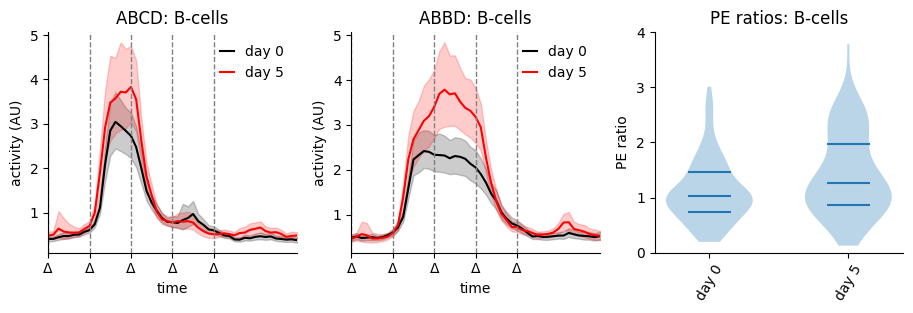

PE ratios, KS-test: KstestResult(statistic=0.2199647839631586, pvalue=0.004734808874693036, statistic_location=1.2724267, statistic_sign=1)


In [6]:
def bootstrap_mean(arr: xr.DataArray) -> Tuple[xr.DataArray]:
    """
    This function finds bootstrapped mean traces with 95% confidence intervals.
    """
    n_iters = 1000
    n_rois = arr.sizes['roi']
    means = []
    for i in range(n_iters):
        inds = np.random.choice(n_rois, n_rois, replace=True)
        sub = arr.isel(roi=inds)
        means.append(sub.mean('roi'))
    means = np.stack(means)
    low = xr.DataArray(np.percentile(means, 2.5, axis=0), dims=('time',))
    mean = xr.DataArray(np.mean(means, axis=0), dims=('time',))
    high = xr.DataArray(np.percentile(means, 97.5, axis=0), dims=('time',))
    return low, mean, high

# Get indices of ROIs/cells that are selective for stimulus B (in any context).
B_IDs_0 = utils.get_IDs(0, 'B')
B_IDs_5 = utils.get_IDs(5, 'B')

# Get trial-averaged responses for B-selective cells.
ABCD_0 = utils.load_traces(0, 'ABCD').mean('trial').isel(roi=B_IDs_0)
ABBD_0 = utils.load_traces(0, 'ABBD').mean('trial').isel(roi=B_IDs_0)
ABCD_5 = utils.load_traces(5, 'ABCD').mean('trial').isel(roi=B_IDs_5)
ABBD_5 = utils.load_traces(5, 'ABBD').mean('trial').isel(roi=B_IDs_5)

# Plot mean traces.
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

# - plot ABCD mean traces
ax = axes[0]
arr = ABCD_0
low, mean, high = bootstrap_mean(arr)
X = np.arange(len(low))
ax.fill_between(X, low, high, color='black', alpha=0.2)
ax.plot(X, mean, color='black', label='day 0')

arr = ABCD_5
low, mean, high = bootstrap_mean(arr)
X = np.arange(len(low))
ax.fill_between(X, low, high, color='red', alpha=0.2)
ax.plot(X, mean, color='red', label='day 5')

utils.annotate_onsets(ax, arr.coords['event'])
ax.legend(handlelength=1, frameon=False, loc='upper right')
ax.set_xlim([0, 48])
ax.set_title('ABCD: B-cells')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('activity (AU)')
ax.set_xlabel('time')

# - plot ABBD mean traces
ax = axes[1]
arr = ABBD_0
low, mean, high = bootstrap_mean(arr)
X = np.arange(len(low))
ax.fill_between(X, low, high, color='black', alpha=0.2)
ax.plot(X, mean, color='black', label='day 0')

arr = ABBD_5
low, mean, high = bootstrap_mean(arr)
X = np.arange(len(low))
ax.fill_between(X, low, high, color='red', alpha=0.2)
ax.plot(X, mean, color='red', label='day 5')

utils.annotate_onsets(ax, arr.coords['event'])
ax.legend(handlelength=1, frameon=False, loc='upper right')
ax.set_xlim([0, 48])
ax.set_title('ABBD: B-cells')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('activity (AU)')
ax.set_xlabel('time')

# - Compute prediction error ratios, AB(B)D vs A(B)BD
B_0 = ABBD_0.isel(time=slice(10, 18)).mean('time')
B_nov_0 = ABBD_0.isel(time=slice(18, 26)).mean('time')
B_5 = ABBD_5.isel(time=slice(10, 18)).mean('time')
B_nov_5 = ABBD_5.isel(time=slice(18, 26)).mean('time')
# - Note that we could 'normalize' by A(B)CD with the following commented
#  out lines. It doesn't change the overall result.
# B_0 = ABCD_0.isel(time=slice(10, 18)).mean('time')
# B_5 = ABCD_5.isel(time=slice(10, 18)).mean('time')

B_diff_0 = B_nov_0 / B_0
B_diff_5 = B_nov_5 / B_5

# - Plot prediction error ratios
ax = axes[2]
positions = [1, 1.8]
ax.violinplot(
    [B_diff_0, B_diff_5],
    positions=positions,
    showextrema=False,
    showmeans=False,
    quantiles=[[0.25, 0.5, 0.75],[0.25, 0.5, 0.75]],
)
ax.set_ylim([0, 4])
ax.set_ylabel('PE ratio')
ax.set_xticks(positions)
ax.set_xticklabels(['day 0', 'day 5'], rotation=60)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('PE ratios: B-cells')
fig.tight_layout(pad=0.25)
plt.show()

# Report KS-test
print(f'PE ratios, KS-test: {ks_2samp(B_diff_0, B_diff_5)}')

There are clear differences in B-responsive cells with training during the omitted element. Consistent with the predictive processing framework, there appears to be a subset of cells that increase their firing during an omitted stimulus. Also of note, cells tend to continue firing throughout a stimulus rather than having a large transient response at stimulus onset (left). PE ratios are significantly different after training compared with before training (right).


###Substitution Prediction Errors
Let's perform the same analysis on C-responsive cells focusing on responses during A**C**BD vs AB**C**D.

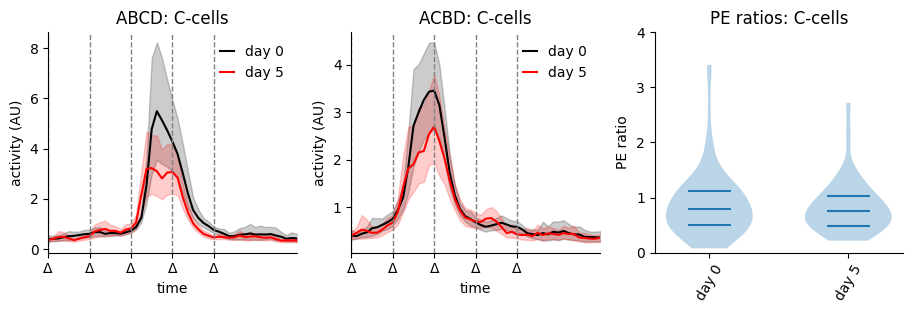

PE ratios, KS-test: KstestResult(statistic=0.13685897435897437, pvalue=0.6395919753448719, statistic_location=0.36176834, statistic_sign=1)


In [7]:
# Get indices of ROIs/cells that are selective for stimulus B (in any context).
C_IDs_0 = utils.get_IDs(0, 'C')
C_IDs_5 = utils.get_IDs(5, 'C')

# Get trial-averaged responses for B-selective cells.
ABCD_0 = utils.load_traces(0, 'ABCD').mean('trial').isel(roi=C_IDs_0)
ACBD_0 = utils.load_traces(0, 'ACBD').mean('trial').isel(roi=C_IDs_0)
ABCD_5 = utils.load_traces(5, 'ABCD').mean('trial').isel(roi=C_IDs_5)
ACBD_5 = utils.load_traces(5, 'ACBD').mean('trial').isel(roi=C_IDs_5)

# Plot mean traces.
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

# - plot ABCD mean traces
ax = axes[0]
arr = ABCD_0
low, mean, high = bootstrap_mean(arr)
X = np.arange(len(low))
ax.fill_between(X, low, high, color='black', alpha=0.2)
ax.plot(X, mean, color='black', label='day 0')

arr = ABCD_5
low, mean, high = bootstrap_mean(arr)
X = np.arange(len(low))
ax.fill_between(X, low, high, color='red', alpha=0.2)
ax.plot(X, mean, color='red', label='day 5')

utils.annotate_onsets(ax, arr.coords['event'])
ax.legend(handlelength=1, frameon=False, loc='upper right')
ax.set_xlim([0, 48])
ax.set_title('ABCD: C-cells')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('activity (AU)')
ax.set_xlabel('time')

# - plot ACBD mean traces
ax = axes[1]
arr = ACBD_0
low, mean, high = bootstrap_mean(arr)
X = np.arange(len(low))
ax.fill_between(X, low, high, color='black', alpha=0.2)
ax.plot(X, mean, color='black', label='day 0')

arr = ACBD_5
low, mean, high = bootstrap_mean(arr)
X = np.arange(len(low))
ax.fill_between(X, low, high, color='red', alpha=0.2)
ax.plot(X, mean, color='red', label='day 5')

utils.annotate_onsets(ax, arr.coords['event'])
ax.legend(handlelength=1, frameon=False, loc='upper right')
ax.set_xlim([0, 48])
ax.set_title('ACBD: C-cells')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('activity (AU)')
ax.set_xlabel('time')

# - Compute prediction error ratios, AB(B)D vs A(B)BD
C_0 = ABCD_0.isel(time=slice(18, 26)).mean('time')
C_nov_0 = ACBD_0.isel(time=slice(10, 18)).mean('time')
C_5 = ABCD_5.isel(time=slice(18, 26)).mean('time')
C_nov_5 = ACBD_5.isel(time=slice(10, 18)).mean('time')


C_diff_0 = C_nov_0 / C_0
C_diff_5 = C_nov_5 / C_5

# - Plot prediction error ratios
ax = axes[2]
positions = [1, 1.8]
ax.violinplot(
    [C_diff_0, C_diff_5],
    positions=positions,
    showextrema=False,
    showmeans=False,
    quantiles=[[0.25, 0.5, 0.75],[0.25, 0.5, 0.75]],
)
ax.set_ylim([0, 4])
ax.set_ylabel('PE ratio')
ax.set_xticks(positions)
ax.set_xticklabels(['day 0', 'day 5'], rotation=60)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('PE ratios: C-cells')
fig.tight_layout(pad=0.25)
plt.show()

# Report KS-test
print(f'PE ratios, KS-test: {ks_2samp(C_diff_0, C_diff_5)}')

We do not see elevated activity driven by a substituion of C with B. If anything, responses are reduced. PE ratios are not significantly different between days.

## Principal Component and Sparsity Analysis
We wanted to see if there are significant changes to the dimensionality of the data and whether sparsification facilitated separability in principal component space.

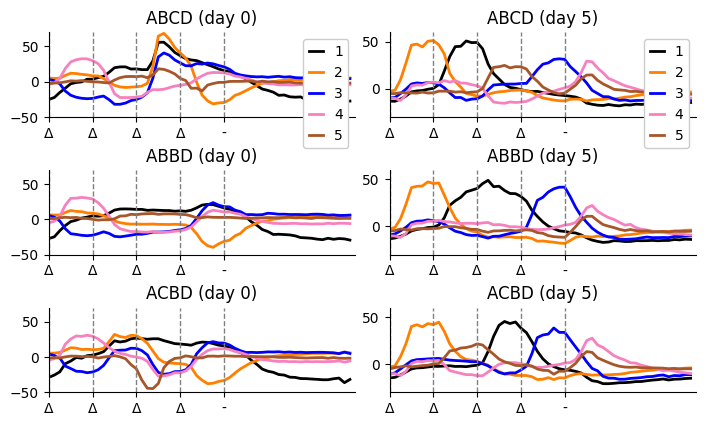

In [8]:
def fill_axes(
    ax: "matplotlib.axes.Axes",
    dct: dict,
    name: str,
    ) -> None:
    """
    Helper function that plots principal components.
    """
    data = dct[name]
    to_flip = dct['to_flip']
    day = dct['day']
    ax.set_prop_cycle(custom_cycler)
    for i in range(n_components):
        arr = data.isel(component=i)
        if i in to_flip:
            arr = -1 * arr
        ax.plot(arr, label=str(i + 1))
    utils.annotate_onsets(ax, data.coords['event'], skip_first=False, last="-")
    ax.set_xlim([0, len(data)])
    ax.set_title(f'{name} (day {day})')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if day == 5:
        ax.set_ylim([-30, 60])
    else:
        ax.set_ylim([-50, 70])

# number of principal components to show
n_components = 5

# custom color-blind friend palette
custom_cycler = (cycler(color=['black', '#ff7f00', 'blue',
                               '#f781bf', '#a65628', '#984ea3',
                               '#999999', '#e41a1c', '#dede00']
                        ) + cycler(lw=[2] * 9))

# Collect traces, do PCA.
info = {0: dict(day=0), 5: dict(day=5)}
for day, dct in info.items():

  # Concatenate trial-averaged responses across sequences  .
  ABCD = utils.load_traces(day, 'ABCD').mean('trial')
  ABBD = utils.load_traces(day, 'ABBD').mean('trial')
  ACBD = utils.load_traces(day, 'ACBD').mean('trial')
  data_in = xr.concat([ABCD, ABBD, ACBD], 'time')

  # Do PCA
  pca = PCA()
  tformed = xr.DataArray(pca.fit_transform(data_in), dims=('time', 'component'))
  tformed.coords['event'] = data_in.coords['event']

  # Add to info dict
  dct['ABCD'] = ABCD
  dct['ABBD'] = ABBD
  dct['ACBD'] = ACBD
  dct['pca'] = pca
  # Split transformed data into sequences.
  ABCD_T = dct['ABCD'] = tformed.isel(time=slice(0, 56))
  ABBD_T = dct['ABBD'] = tformed.isel(time=slice(56, 112))
  ACBD_T = dct['ACBD'] = tformed.isel(time=slice(112, 168))

  # Flip components upside down if they tend to go more negative.
  to_flip = []
  for i in range(n_components):
      arr = ABCD_T.isel(component=i)
      if abs(arr.min()) > abs(arr.max()):
          to_flip.append(i)

  # Add to info dict
  dct['to_flip'] = to_flip


fig, axes = plt.subplots(3, 2, figsize=(7, 4.2))

# day 0
fill_axes(axes[0, 0], info[0], 'ABCD')
axes[0, 0].legend(loc='upper right', framealpha=1, handlelength=1)
fill_axes(axes[1, 0], info[0], 'ABBD')
fill_axes(axes[2, 0], info[0], 'ACBD')
# day 5
fill_axes(axes[0, 1], info[5], 'ABCD')
axes[0, 1].legend(loc='upper right', framealpha=1, handlelength=1)
fill_axes(axes[1, 1], info[5], 'ABBD')
fill_axes(axes[2, 1], info[5], 'ACBD')

plt.tight_layout(pad=0.5)
plt.show()


According to theory, a sparser network yields less correlated patterns. For each sequence presentation, we calculated the Pearson correlation coefficients between all pairs of stimuli, yielding a collection of coefficients for each sequence on each day.

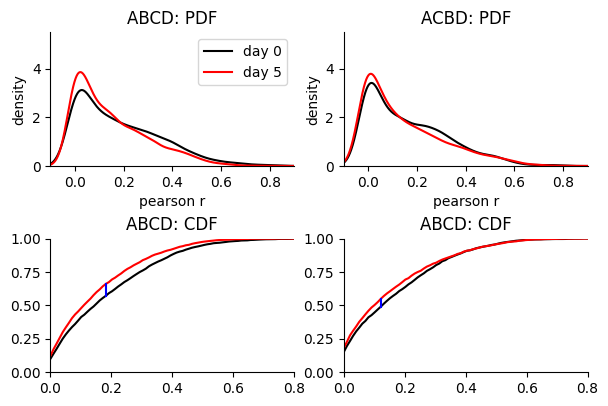

In [9]:
def get_correlations(day: int, sequence: str) -> np.ndarray:
  """
  Compute pearson correlation coefficients between all
  pairs of stimulus-driven responses in each trial. There are
  four images in each trial (e.g., A, B, C D). There are six
  pairs per trial (A-B, A-C, etc.) and 500 trials, so this
  yields 3000 samples.

  """
  seq = utils.load_traces(day, sequence, drop_gray=True)
  arrays = utils.split_by_event(seq)

  # Time-average each presentation
  for i, arr in enumerate(arrays):
    arrays[i] = arr.mean('time')

  # Get pairwise correlations between all pairs of population
  # vectors in a given trial.
  corrs = []
  for t in range(500):
      lst = [elt.isel(trial=t) for elt in arrays]
      for i in range(len(lst) - 1):
          for j in range(i + 1, len(lst)):
              c = pearsonr(lst[i], lst[j]).statistic
              corrs.append(c)
  return np.array([corrs]).flatten()


ABCD_0 = get_correlations(0, 'ABCD')
ACBD_0 = get_correlations(0, 'ACBD')
ABCD_5 = get_correlations(5, 'ABCD')
ACBD_5 = get_correlations(5, 'ACBD')

fig, axes = plt.subplots(2, 2, figsize=(6, 4))

# ABCD

# - PDF
ax = axes[0, 0]
X = np.linspace(-0.1, 0.9, 1000)
Y = gaussian_kde(ABCD_0)(X)
ax.plot(X, Y, color='black', label='day 0')
Y = gaussian_kde(ABCD_5)(X)
ax.plot(X, Y, color='red', label='day 5')
ax.legend()
ax.set_title('ABCD: PDF')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([-0.1, 0.9])
ax.set_ylim([0, 5.5])
ax.set_ylabel('density')
ax.set_xlabel('pearson r')

# - CDF
ax = axes[1, 0]
cdf0 = ecdf(ABCD_0).cdf
cdf5 = ecdf(ABCD_5).cdf
X = np.linspace(0, 1, 100)
y0 = cdf0.evaluate(X)
y5 = cdf5.evaluate(X)
diffs = np.abs(y5 - y0)
imax = np.nanargmax(diffs)
ax.plot(X, y0, color='black')
ax.plot(X, y5, color='red')
ax.plot([X[imax], X[imax]], [y0[imax], y5[imax]], color='blue')
ax.set_xlim([0.0, 0.8])
ax.set_ylim([0, 1])
ax.set_title('ABCD: CDF')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ACBD

# - PDF
ax = axes[0, 1]
X = np.linspace(-0.1, 0.9, 1000)
Y = gaussian_kde(ACBD_0)(X)
ax.plot(X, Y, color='black', label='day 0')
Y = gaussian_kde(ACBD_5)(X)
ax.plot(X, Y, color='red', label='day 5')
ax.set_title('ACBD: PDF')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([-0.1, 0.9])
ax.set_ylim([0, 5.5])
ax.set_ylabel('density')
ax.set_xlabel('pearson r')

# - CDF
ax = axes[1, 1]
cdf0 = ecdf(ACBD_0).cdf
cdf5 = ecdf(ACBD_5).cdf
X = np.linspace(0, 1, 100)
y0 = cdf0.evaluate(X)
y5 = cdf5.evaluate(X)
diffs = np.abs(y5 - y0)
imax = np.nanargmax(diffs)
ax.plot(X, y0, color='black')
ax.plot(X, y5, color='red')
ax.plot([X[imax], X[imax]], [y0[imax], y5[imax]], color='blue')
ax.set_xlim([0.0, 0.8])
ax.set_ylim([0, 1])
ax.set_title('ABCD: CDF')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout(pad=0.5)
plt.show()


Correlations were reduced by 10-20% on day 5 compared with day 0. This, coupled with the overall descraese in number of cells responding to visual stimulation, suggests that experience-dependent spatiotemporal plasticity increases coding efficiency.

We asked whether the changes in the population code had a measurable effect on the decodability of stimuli. We trained a linear decoder (scikit-learn, svm.SVC) on time-averaged responses to all events and assessed their performance on a held-out testing datset. 100 training/testing iterations were performed. See 'decode_events.py' to see how this was done. Here we'll just load the results of the training/testing as a collection of confusion matrices.

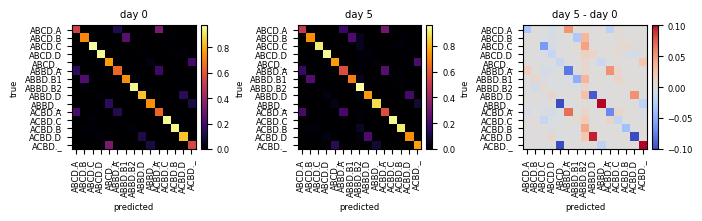

day 0: mean=0.7851226666666666, 95% CI: 0.508, 0.98
day 5: mean=0.7686506666666667, 95% CI: 0.488, 0.964


In [10]:
# Load precomputed confusion matrices.
with h5py.File(DATA_DIR / 'decode_events.h5', 'r') as f:
  cmats_0 = f['day_0'][:]
  cmats_5 = f['day_5'][:]

# Compute average confusion matrices (100 iterations), and
# normalize by number of decodings (e.g., size of testing dataset).
cm_0 = cmats_0.mean(axis=0) / 250
cm_5 = cmats_5.mean(axis=0) / 250

labels = [
    'ABCD.A',
    'ABCD.B',
    'ABCD.C',
    'ABCD.D',
    'ABCD._',
    'ABBD.A',
    'ABBD.B1',
    'ABBD.B2',
    'ABBD.D',
    'ABBD._',
    'ACBD.A',
    'ACBD.C',
    'ACBD.B',
    'ACBD.D',
    'ACBD._',
]

plt.rcParams['font.size'] = 6
fig, axes = plt.subplots(1, 3, figsize=(7, 2.25))

ax, mat = axes[0], cm_0
im = ax.imshow(mat, cmap='inferno')
ax.set_title(f"day 0")
ax.set_xlabel('predicted')
ax.set_ylabel('true')
divider = make_axes_locatable(ax)
ax_cb = divider.append_axes("right", size="5%", pad=0.05)
fig.add_axes(ax_cb)
plt.colorbar(im, cax=ax_cb)
ax_cb.yaxis.tick_right()
ax_cb.yaxis.set_tick_params(labelright=True)

ax, mat = axes[1], cm_5
im = ax.imshow(mat, cmap="inferno")
ax.set_title(f"day 5")
ax.set_xlabel('predicted')
ax.set_ylabel('true')
divider = make_axes_locatable(ax)
ax_cb = divider.append_axes("right", size="5%", pad=0.05)
fig.add_axes(ax_cb)
plt.colorbar(im, cax=ax_cb)
ax_cb.yaxis.tick_right()
ax_cb.yaxis.set_tick_params(labelright=True)

ax, mat = axes[2], cm_5 - cm_0
v_extreme = 0.1
im = ax.imshow(mat, 'coolwarm', vmin=-v_extreme, vmax=v_extreme)
ax.set_title(f"day 5 - day 0")
ax.set_xlabel('predicted')
ax.set_ylabel('true')
divider = make_axes_locatable(ax)
ax_cb = divider.append_axes("right", size="5%", pad=0.05)
fig.add_axes(ax_cb)
cbar = plt.colorbar(im, cax=ax_cb)
ax_cb.yaxis.tick_right()
ax_cb.yaxis.set_tick_params(labelright=True)

ticks = np.arange(len(labels))
for ax in axes:
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)

fig.tight_layout(pad=0.7)
plt.show()

# Compute accuracy statistics of event decoder
for day, cmats in zip(['day 0', 'day 5'], [cmats_0, cmats_5]):
  cmats = utils.normalize_confusion_matrices(cmats)
  acc = np.stack([np.diag(m) for m in cmats])
  mean = acc.mean()
  low, high = np.percentile(acc, [2.5, 97.5])
  print(f'{day}: mean={mean}, 95% CI: {low}, {high}')


Training did not significantly alter decodability, at least with respect to the SVM. Without a behavioral assay, it is not possible to know whether, for example, higher visual cortical areas better decode information from V1 directly.
<br>
<br>
However, note the ability to differentiate between A from ABCD and A from ABBD. In these two cases, both events have the same stimulus and a preceded by a long (1 s) rest period. We considered the possibility that this may be due to long-timescael representational drift. To test this idea, we performed two analyses. First, the trained a decoder to discern which block a stimulus response came from (recall sequences were presented in blocks of 100).

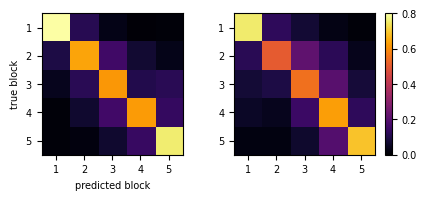

day 0 accuracy: 0.6926666666666668
day 5 accuracy: 0.6256666666666667


In [11]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix


def get_cmats(day: int, sequence: str) -> np.ndarray:

    data = utils.load_traces(day, sequence, drop_gray=True)
    arrays = utils.split_by_event(data)

    # Iterate through each event in this sequence (there are 4),
    # and compute a confusion matrix for each.
    cmats = []
    for elt_num in range(4):
      arr = arrays[elt_num]
      arr = arr.isel(time=slice(2, None)).mean('time')

      # For each block, add to train/test splits.
      X_train, X_test = [], []
      y_train, y_test = [], []
      for i in range(0, 500, 100):
          block = arr.isel(trial=slice(i, i + 100))
          train_inds = np.random.choice(100, 50, replace=False)
          test_inds = np.setdiff1d(np.arange(100), train_inds)
          X_train.append(block.isel(trial=train_inds))
          y_train.append(np.full(50, i))
          X_test.append(block.isel(trial=test_inds))
          y_test.append(np.full(50, i))

      X_train = xr.concat(X_train, 'trial')
      y_train = np.concatenate(y_train)
      X_test = xr.concat(X_test, 'trial')
      y_test = np.concatenate(y_test)

      clf = SVC(kernel='rbf')
      clf.fit(X_train, y_train)
      predictions = clf.predict(X_test)

      # confusion matrix
      cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
      cm = utils.normalize_confusion_matrix(cm)
      cmats.append(cm)

    # combine and return confusion matrices
    return np.stack(cmats)


cmats = []
for sequence in ('ABCD', 'ABBD', 'ACBD'):
    cmats.append(get_cmats(0, sequence))
cm_0 = np.concatenate(cmats).mean(axis=0)

cmats = []
for sequence in ('ABCD', 'ABBD', 'ACBD'):
    cmats.append(get_cmats(5, sequence))
cm_5 = np.concatenate(cmats).mean(axis=0)

plt.rcParams['font.size'] = 7
fig, axes = plt.subplots(1, 2, figsize=(4.5, 2))

ax = axes[0]
im = ax.imshow(cm_0, cmap='inferno', vmin=0, vmax=0.8)
ticks = np.arange(5)
tick_labels = ['1', '2', '3', '4', '5']
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)
ax.set_yticks(ticks)
ax.set_yticklabels(tick_labels)
ax.set_xlabel('predicted block')
ax.set_ylabel('true block')

ax = axes[1]
im = ax.imshow(cm_5, cmap='inferno', vmin=0, vmax=0.8)
ticks = np.arange(5)
tick_labels = ['1', '2', '3', '4', '5']
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)
ax.set_yticks(ticks)
ax.set_yticklabels(tick_labels)
plt.colorbar(im)

fig.tight_layout(pad=1)
plt.show()


acc_0 = np.diag(cm_0).mean()
acc_5 = np.diag(cm_5).mean()
print(f'day 0 accuracy: {acc_0}')
print(f'day 5 accuracy: {acc_5}')

The linear decoder is able to accuractely classify which block responses came from, with errors decreasing with distance between blocks (e.g., block 1 is often confused with block 2 but not block 5). This is strong evidence for representational drift.
<br>
<br>
We tested this further by measuring Pearson correlation coefficients between all pairs of population vectors driven by a particular sequence element and grouped these values by how far apart the pairs were in time/trial. This computation takes time, so we'll load the pre-computed results. See 'representational_drift.py' for the full code.

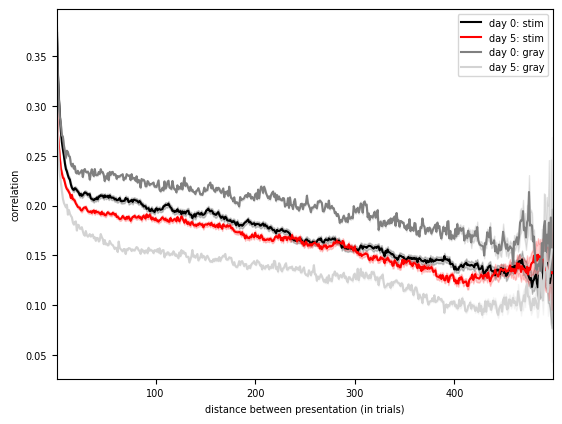

In [12]:


with h5py.File(DATA_DIR / 'drift_correlations.h5', 'r') as f:
    stim_0 = f['day_0/stim'][:]
    gray_0 = f['day_0/gray'][:]
    stim_5 = f['day_5/stim'][:]
    gray_5 = f['day_5/gray'][:]


fig, ax = plt.subplots()

data = stim_0[:, 1:]
mean = data.mean(axis=0)
std = np.std(data, axis=0)
N = np.arange(499, 1, -1)
sem = std / np.sqrt(N)
ymin = mean - sem
ymax = mean + sem
X = np.arange(len(mean)) + 1
ax.plot(X, mean, color='black', label='day 0: stim')
ax.fill_between(X, ymin,  ymax, color='black', alpha=0.2)

data = stim_5[:, 1:]
mean = data.mean(axis=0)
std = np.std(data, axis=0)
N = np.arange(499, 1, -1)
sem = std / np.sqrt(N)
ymin = mean - sem
ymax = mean + sem
X = np.arange(len(mean)) + 1
ax.plot(X, mean, color='red', label='day 5: stim')
ax.fill_between(X, ymin,  ymax, color='red', alpha=0.2)

data = gray_0[:, 1:]
mean = data.mean(axis=0)
std = np.std(data, axis=0)
N = np.arange(499, 1, -1)
sem = std / np.sqrt(N)
ymin = mean - sem
ymax = mean + sem
X = np.arange(len(mean)) + 1
ax.plot(X, mean, color='gray', label='day 0: gray')
ax.fill_between(X, ymin,  ymax, color='gray', alpha=0.2)

data = gray_5[:, 1:]
mean = data.mean(axis=0)
std = np.std(data, axis=0)
N = np.arange(499, 1, -1)
sem = std / np.sqrt(N)
ymin = mean - sem
ymax = mean + sem
X = np.arange(len(mean)) + 1
ax.plot(X, mean, color='lightgray', label='day 5: gray')
ax.fill_between(X, ymin,  ymax, color='lightgray', alpha=0.2)

ax.set_xlim([1, 499])
ax.legend()
ax.set_xlabel('distance between presentation (in trials)')
ax.set_ylabel('correlation')
plt.show()




## Changes to Temporal Code

We analyzed responses in terms of stimulus-locking and other changes to the temporal coordination of neural populations.

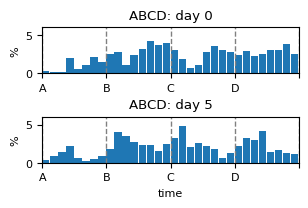

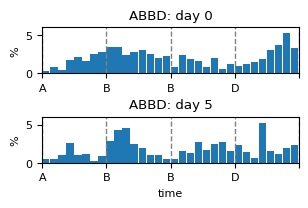

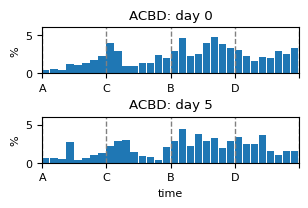

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import utils



def filter_consistent(arr: xr.DataArray, tol: int) -> xr.DataArray:
    even_inds = np.arange(0, arr.sizes['trial'], 2)
    even = arr.isel(trial=even_inds).mean('trial')
    odd = arr.isel(trial=even_inds + 1).mean('trial')
    even_scores = even.argmax('time')
    odd_scores = odd.argmax('time')
    delta = np.abs(even_scores - odd_scores)
    arg_good = utils.argwhere(delta < tol)
    out = arr.isel(roi=arg_good)
    return out


"""
Create histograms of max firing rates from onset of a sequence.
"""

def plot_sequence_timefields(sequence: str) -> None:

    # consistently tolerance
    tol = 4

    # Load traces
    day_0 = utils.load_traces(0, sequence)
    day_5 = utils.load_traces(5, sequence)

    # Filter out cell without consistent firing timefields
    day_0 = filter_consistent(day_0, tol).mean('trial')
    day_5 = filter_consistent(day_5, tol).mean('trial')

    # plot distance from onset.
    plt.rcParams['font.size'] = 8
    fig, axes = plt.subplots(2, 1, figsize=(3, 2))
    bins = np.arange(0, day_0.sizes['time'] + 1) - 0.5

    ax, arr = axes[0], day_0
    scores_0 = arr.argmax('time')
    hist = ax.hist(scores_0, bins=bins, width=0.9, density=True)
    ax.set_title(f'{sequence}: day 0')

    ax, arr = axes[1], day_5
    scores_5 = arr.argmax('time')
    ax.hist(scores_5, bins=bins, width=0.9, density=True)
    ax.set_xlabel('time')
    ax.set_title(f'{sequence}: day 5')

    xticklabels = list(sequence)
    xticklabels.append('')
    for ax in axes:
        utils.annotate_onsets(ax, day_0.coords['event'], shift=-0.5)
        ax.set_xlim([-0.5, 31.5])
        ax.set_ylim([0, 0.06])
        ax.set_xticklabels(xticklabels)
        ax.set_yticks([0, 0.05])
        ax.set_yticklabels(['0', '5'])
        ax.set_ylabel('%')

    fig.tight_layout(pad=0.5)
    plt.show()


plot_sequence_timefields('ABCD')
plot_sequence_timefields('ABBD')
plot_sequence_timefields('ACBD')



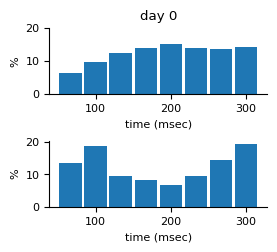

In [25]:


def collect_counts(day: int, tol:int = 4, offset: int = 2) -> np.ndarray:
    """
    """

    arr = utils.load_traces(day, 'ABCD')
    arr = filter_consistent(arr, tol)
    scores = arr.mean('trial').argmax('time')
    bins = np.arange(0, arr.sizes['time'] + 1) - 0.5
    vals, _ = np.histogram(scores, bins=bins)
    counts = vals[0 + offset:8 + offset]
    counts += vals[8 + offset:16 + offset]
    counts += vals[16 + offset:24 + offset]
    counts += vals[24 + offset:32 + offset]

    arr = utils.load_traces(day, 'ABBD')
    arr = filter_consistent(arr, tol)
    scores = arr.mean('trial').argmax('time')
    vals, _ = np.histogram(scores, bins=bins)
    counts += vals[0 + offset:8 + offset]
    counts += vals[8 + offset:16 + offset]
    counts += vals[24 + offset:32 + offset]

    arr = utils.load_traces(day, 'ACBD')
    arr = filter_consistent(arr, tol)
    scores = arr.mean('trial').argmax('time')
    vals, _ = np.histogram(scores, bins=bins)
    counts += vals[0 + offset:8 + offset]
    counts += vals[8 + offset:16 + offset]
    counts += vals[16 + offset:24 + offset]
    counts += vals[24 + offset:32 + offset]

    return counts / counts.sum()



counts_0 = collect_counts(0)
counts_5 = collect_counts(5)

fig, axes = plt.subplots(2, 1, figsize=(2.75, 2.5))

ax, counts = axes[0], counts_0
X = np.arange(len(counts)) + 0.5
ax.bar(X, counts, width=0.9)
ax.set_title('day 0')

ax, counts = axes[1], counts_5
X = np.arange(len(counts)) + 0.5
ax.bar(X, counts, width=0.9)


xticks = np.array([1, 4, 7]) + 0.5
xticklabels = ['100', '200', '300']
for ax in axes:
    ax.set_xlabel('time (msec)')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([0.0 ,0.1, 0.2])
    ax.set_yticklabels([0, 10, 20])
    ax.set_ylabel('%')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.tight_layout(pad=0.8)
plt.show()
